# CT650 Group Assignment 1
## Car_Rates.csv
## by :
- ### Mostafa Mohamed Mohamed Imam
- ### Mervat Khaled Emam
## 

### Questions :
- #### Can we segment cars based on their customer feedback (brand classification) ?
 

In [3]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import isnan, when, count, col, skewness, kurtosis, lit, mean as _mean, stddev as _stddev, log
from pyspark.sql.window import Window
from pyspark.mllib.stat import Statistics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, IndexToString
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import DataFrame
from typing import List, Dict
import logging
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
SparkSession.getActiveSession()

In [5]:
spark = SparkSession.builder \
    .master("local")\
    .appName("CT650_GA1_Car_Rates") \
    .getOrCreate()

In [6]:
#spark data frame
car_rates_sdf=spark.read.csv(
    path="Car_Rates.csv",
    header=True,
    inferSchema=True
)

In [7]:
car_rates_sdf.show(5)

+--------------------+--------------+------------+-------+---------------+-----------+-------------------+----------------+-----------+----+-----+--------+
|            Car_name|Num_of_reviews|General_rate|Comfort|Interior design|Performance|Value for the money|Exterior styling|Reliability|Year|Brand|   Model|
+--------------------+--------------+------------+-------+---------------+-----------+-------------------+----------------+-----------+----+-----+--------+
|2023     Acura   ...|           5.0|         4.6|    4.4|            4.4|        4.6|                4.2|             5.0|        4.8|2023|Acura|Integra.|
|2023     Acura   ...|          NULL|        NULL|   NULL|           NULL|       NULL|               NULL|            NULL|       NULL|2023|Acura|    MDX.|
|2023     Acura   ...|          NULL|        NULL|   NULL|           NULL|       NULL|               NULL|            NULL|       NULL|2023|Acura|    TLX.|
|2023     Acura   ...|          NULL|        NULL|   NULL|      

In [8]:
car_rates_sdf.printSchema()

root
 |-- Car_name: string (nullable = true)
 |-- Num_of_reviews: double (nullable = true)
 |-- General_rate: double (nullable = true)
 |-- Comfort: double (nullable = true)
 |-- Interior design: double (nullable = true)
 |-- Performance: double (nullable = true)
 |-- Value for the money: double (nullable = true)
 |-- Exterior styling: double (nullable = true)
 |-- Reliability: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Model: string (nullable = true)



In [9]:
print(f"Columns are:\t{car_rates_sdf.columns}, \n Number of columns: {len(car_rates_sdf.columns)}\n Number of rows: {car_rates_sdf.count()}")

Columns are:	['Car_name', 'Num_of_reviews', 'General_rate', 'Comfort', 'Interior design', 'Performance', 'Value for the money', 'Exterior styling', 'Reliability', 'Year', 'Brand', 'Model'], 
 Number of columns: 12
 Number of rows: 4243


In [10]:
def analyze_data_extra(df):
    """
    Analyzes the Spark DataFrame to provide insights for model fitting.
    It performs statistical tests, plots the correlation matrix, and recommends
    data transformations if needed.
    
    Parameters:
    df (DataFrame): A Spark DataFrame containing car data with potential null values.
    
    Returns:
    DataFrame: The cleaned Spark DataFrame after dropping null values.
    """
    # Define categorical and numerical columns
    categorical_cols = ['Car_name', 'Year', 'Brand', 'Model']
    numerical_cols = ['Num_of_reviews', 'General_rate', 'Comfort', 'Interior design',
                      'Performance', 'Value for the money', 'Exterior styling', 'Reliability']

    # Clean the data by removing rows with null values in numerical columns
    df_clean = df.dropna(subset=numerical_cols)

    # Calculate descriptive statistics for numerical columns
    descriptive_stats = df_clean.describe(numerical_cols)

    # Calculate skewness and kurtosis for numerical features
    skewness_results = df_clean.select([skewness(col(c)).alias(c) for c in numerical_cols])
    kurtosis_results = df_clean.select([kurtosis(col(c)).alias(c) for c in numerical_cols])

    # Compute correlations between numerical features
    features_rdd = df_clean.select(numerical_cols).rdd.map(lambda row: [row[c] for c in numerical_cols])
    correlation_matrix = Statistics.corr(features_rdd, method='pearson')

    # Convert correlation matrix to Pandas DataFrame for plotting
    corr_df = pd.DataFrame(correlation_matrix, columns=numerical_cols, index=numerical_cols)

    # Plot the correlation matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Recommendations based on skewness and correlation
    recommendations = []

    # Check for skewness in the data
    skewness_df = skewness_results.collect()[0].asDict()
    for k, v in skewness_df.items():
        str_v = str(v)
        if v > 1:  # Use Python's built-in abs function on a float
            recommendations.append(f"Consider applying a transformation to '{str(k)}' to correct skewness.")
            
    # Check for high correlation between features
    for i in range(len(numerical_cols)):
        for j in range(i+1, len(numerical_cols)):
            if correlation_matrix[i][j] > 0.8:
                recommendations.append(f"High correlation between '{numerical_cols[i]}' and '{numerical_cols[j]}'. Consider dimensionality reduction.")

    # Print the recommendations
    if recommendations:
        print("Recommendations based on the analysis:")
        for rec in recommendations:
            print(rec)
    else:
        print("No significant transformations are recommended based on the analysis.")

    # Show the results
    descriptive_stats.show()
    skewness_results.show()
    kurtosis_results.show()

    # Return the cleaned DataFrame
    return df_clean

# Example usage:
# Assuming 'df' is the Spark DataFrame containing the car data
# cleaned_df = analyze_data(df)


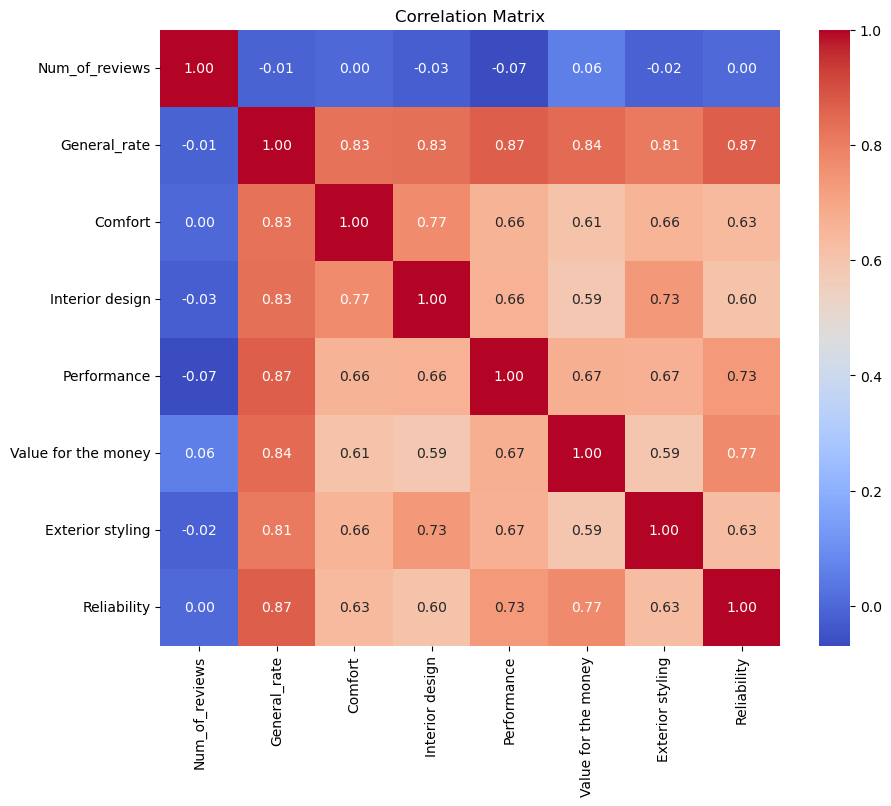

Recommendations based on the analysis:
Consider applying a transformation to 'Num_of_reviews' to correct skewness.
High correlation between 'General_rate' and 'Comfort'. Consider dimensionality reduction.
High correlation between 'General_rate' and 'Interior design'. Consider dimensionality reduction.
High correlation between 'General_rate' and 'Performance'. Consider dimensionality reduction.
High correlation between 'General_rate' and 'Value for the money'. Consider dimensionality reduction.
High correlation between 'General_rate' and 'Exterior styling'. Consider dimensionality reduction.
High correlation between 'General_rate' and 'Reliability'. Consider dimensionality reduction.
+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|summary|   Num_of_reviews|      General_rate|           Comfort|   Interior design|       Performance|Value for the money|  Exterior styling|    

In [11]:
df_clean = analyze_data_extra(car_rates_sdf)

In [12]:
df_clean.show(10)

+--------------------+--------------+------------+-------+---------------+-----------+-------------------+----------------+-----------+----+-----+-----------------+
|            Car_name|Num_of_reviews|General_rate|Comfort|Interior design|Performance|Value for the money|Exterior styling|Reliability|Year|Brand|            Model|
+--------------------+--------------+------------+-------+---------------+-----------+-------------------+----------------+-----------+----+-----+-----------------+
|2023     Acura   ...|           5.0|         4.6|    4.4|            4.4|        4.6|                4.2|             5.0|        4.8|2023|Acura|         Integra.|
|2022     Acura   ...|           3.0|         4.8|    4.3|            4.3|        4.7|                5.0|             5.0|        5.0|2022|Acura|             TLX.|
|2022     Acura   ...|          19.0|         4.7|    4.8|            4.6|        4.7|                4.6|             4.9|        4.6|2022|Acura|             MDX.|
|2022     

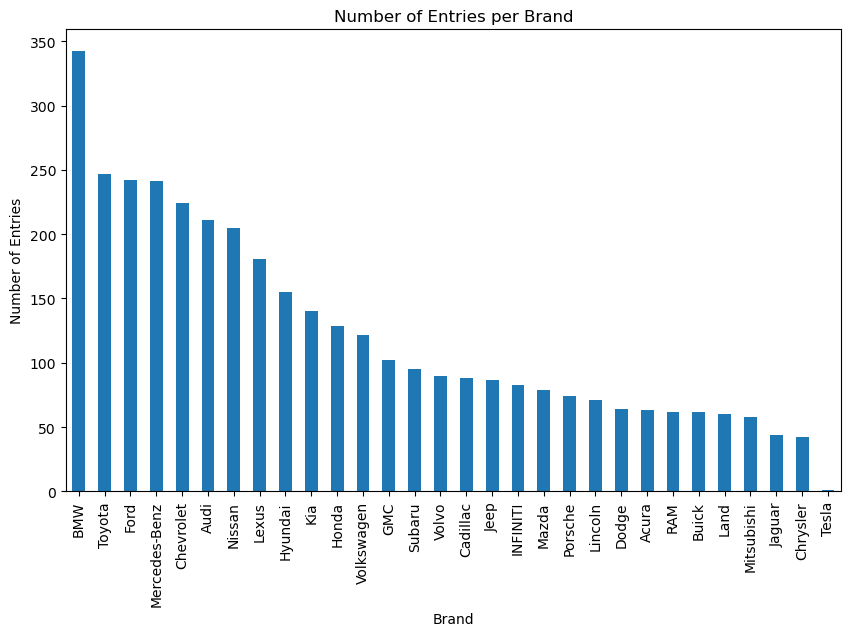

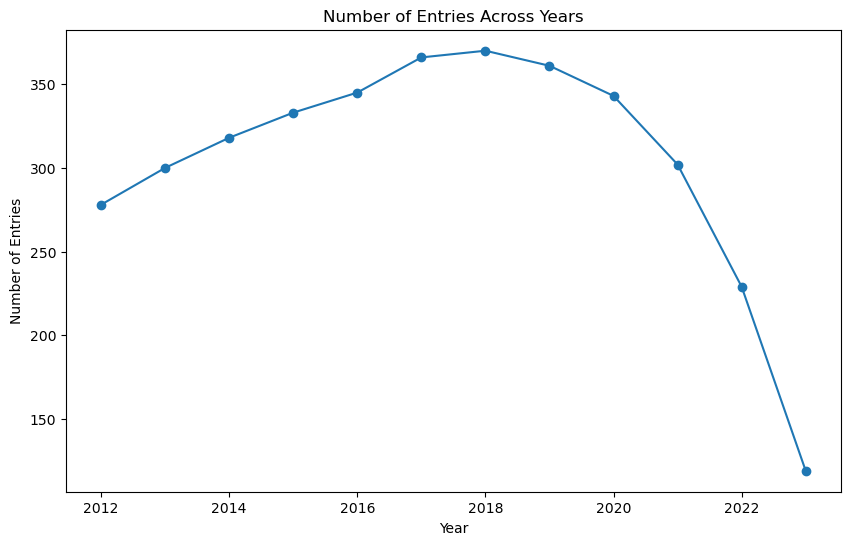

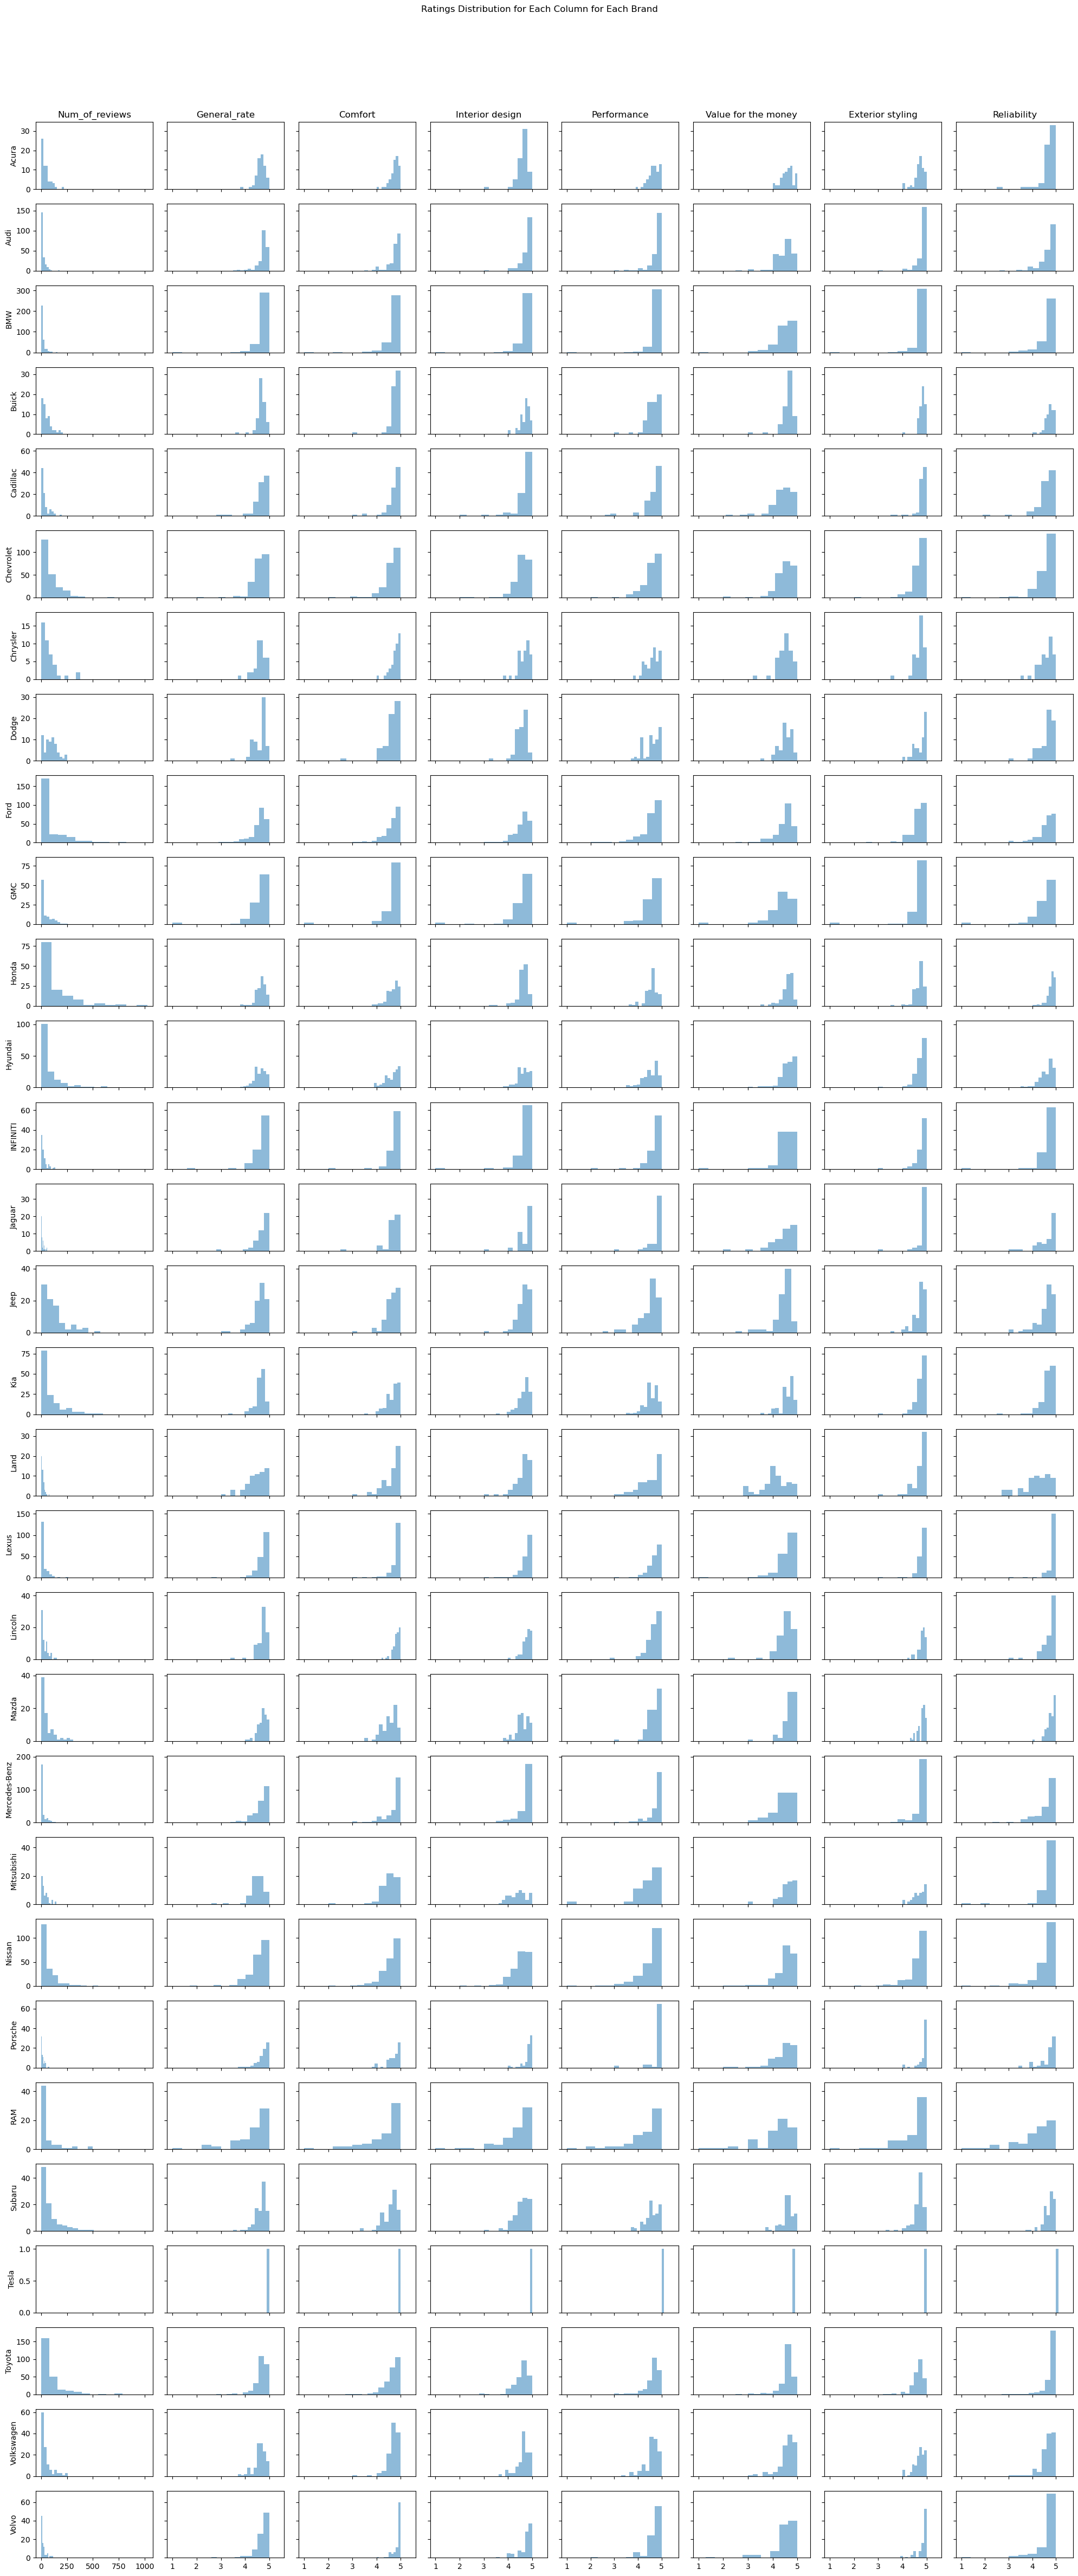

In [16]:
# Convert to Pandas DataFrame for plotting if the data size is manageable
pdf = df_clean.toPandas()

# Bar plot showing the number of entries for each brand
brand_counts = pdf['Brand'].value_counts()
plt.figure(figsize=(10, 6))
brand_counts.plot(kind='bar')
plt.title('Number of Entries per Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Entries')
plt.show()

# Line plot showing the number of entries across years
entries_per_year = pdf.groupby('Year').size()
plt.figure(figsize=(10, 6))
entries_per_year.plot(kind='line', marker='o')
plt.title('Number of Entries Across Years')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.show()

# Matrix of plots for ratings distribution for each column for each brand
rating_columns = ['Num_of_reviews', 'General_rate', 'Comfort', 'Interior design', 'Performance', 'Value for the money', 'Exterior styling', 'Reliability']
brands = pdf['Brand'].unique()

fig, axes = plt.subplots(len(brands), len(rating_columns), figsize=(20, 50), sharex='col', sharey='row')
fig.suptitle('Ratings Distribution for Each Column for Each Brand')

for i, brand in enumerate(brands):
    for j, column in enumerate(rating_columns):
        axes[i, j].hist(pdf[pdf['Brand'] == brand][column], bins=10, alpha=0.5)
        if i == 0:
            axes[i, j].set_title(column)
        if j == 0:
            axes[i, j].set_ylabel(brand)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


As we can see from the plots, the ratings are condensed around very similar margins for all rating metrics for all brands which would make it difficult to classify the entire brands based on rating as opposed to specific models within the brands for example.

In [13]:
def random_forest_classifier(df, feature_cols, target_col):
    """
    Trains a Random Forest classifier on the given DataFrame.

    Args:
        df (DataFrame): Input DataFrame containing features and target column.
        feature_cols (List[str]): List of feature column names.
        target_col (str): Name of the target column.

    Returns:
        DataFrame: DataFrame with predictions and original target labels.

    Example:
        predictions = random_forest_classifier(df, ['Num_of_reviews', 'General_rate', 'Comfort'], 'Brand')
    """
    
    # Handle categorical features using StringIndexer
    categorical_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
    stages = [
        StringIndexer(inputCol=c, outputCol=c + "_indexed").fit(df) for c in categorical_cols if c in feature_cols
    ]
    
    # Index the target variable
    label_indexer = StringIndexer(inputCol=target_col, outputCol="label").fit(df)
    stages.append(label_indexer)
    
    # Assemble numerical features
    numerical_cols = list(set(feature_cols) - set(categorical_cols))
    assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
    stages.append(assembler)
    
    # Random Forest model
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    stages.append(rf)
    
    # Convert indexed labels back to original labels
    label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=label_indexer.labels)
    stages.append(label_converter)
    
    # Create a Pipeline
    pipeline = Pipeline(stages=stages)
    
    # Split the data
    train_data, test_data = df.randomSplit([0.7, 0.3])
    
    # Train the model
    model = pipeline.fit(train_data)
    
    # Make predictions
    predictions = model.transform(test_data)
    
    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"Random Forest Classifier Accuracy: {accuracy}")
    
    return predictions.select(col(target_col), col("predictedLabel"))

# Example usage:
# predictions = random_forest_classifier(df, ['Num_of_reviews', 'General_rate', 'Comfort', ...], 'Brand')


In [14]:
rf_predictions_1 = random_forest_classifier(df_clean, ["Num_of_reviews", "General_rate", "Comfort", "Interior design", "Performance",
                                                        "Value for the money", "Exterior styling", "Reliability"], 'Brand')
print(f"Random Forest Classification:/n{rf_predictions_1}")

Random Forest Classifier Accuracy: 0.17415215398716774
Random Forest Classification:/nDataFrame[Brand: string, predictedLabel: string]


In [21]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def prepare_data(df: DataFrame, numerical_features: List[str], target_feature: str) -> DataFrame:
    """
    Prepares the input DataFrame for classification by handling invalid values and applying log transformation.

    Args:
        df (DataFrame): Input DataFrame containing features and target column.
        numerical_features (List[str]): List of numerical feature column names.
        target_feature (str): Name of the target column.

    Returns:
        DataFrame: Prepared DataFrame with log-transformed numerical features and indexed target labels.
    """
    
    logger.info("Preparing data...")
    # Handle zero or negative values for log transformation
    def handle_invalid_values(df, col):
        invalid_count = df.filter(df[col] <= 0).count()
        if invalid_count > 0:
            logger.info(f"Dropping {invalid_count} records from column '{col}' due to invalid values for log transformation.")
            df = df.filter(df[col] > 0)
        else:
            logger.info(f"No records dropped from column '{col}' as all values are valid for log transformation.")
        return df

    # Apply log transformation safely
    df_log_transformed = df
    for col in numerical_features:
        df_log_transformed = handle_invalid_values(df_log_transformed, col)
        df_log_transformed = df_log_transformed.withColumn(col, log(col))

    # Index the target feature
    label_indexer = StringIndexer(inputCol=target_feature, outputCol="label", handleInvalid='keep').fit(df)
    df = label_indexer.transform(df)
    df_log_transformed = label_indexer.transform(df_log_transformed)

    logger.info("Data preparation complete.")
    return df, df_log_transformed



def classification_model_pipeline(df: DataFrame, numerical_features: List[str], model, param_grid: Dict) ->Dict:
    """
    Creates a classification model pipeline, performs cross-validation, and returns the best model and score.

    Args:
        df (DataFrame): Input DataFrame containing features and target column.
        numerical_features (List[str]): List of numerical feature column names.
        model: Classification model (e.g., RandomForestClassifier, LogisticRegression).
        param_grid (Dict): Parameter grid for hyperparameter tuning.

    Returns:
        Dict: Dictionary with the best model score and best model instance.

    Example:
        results = classification_model_pipeline(df, ['feature1', 'feature2'], RandomForestClassifier(), param_grid)
    """
    
    logger.info(f"Starting classification model pipeline for model: {type(model).__name__}")
    # Assemble numerical features into a single vector column
    assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")

    # Scale features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

    # Evaluator for cross-validation
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    # Build pipeline
    pipeline = Pipeline(stages=[assembler, scaler, model])

    # Cross-validator
    crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

    # Fit the model
    logger.info("Fitting the model...")
    cv_model = crossval.fit(df)
    logger.info("Model fitting complete.")

    # Get the best model and metrics
    best_model = cv_model.bestModel
    best_score = max(cv_model.avgMetrics)
    logger.info(f"Best model score: {best_score}")

    return {'best_score': best_score, 'best_model': best_model}



def run_classification_models(df: DataFrame, numerical_features: List[str], target_feature: str) -> Dict:
    """
    Runs multiple classification models on the input DataFrame and returns evaluation results.

    Args:
        df (DataFrame): Input DataFrame containing features and target column.
        numerical_features (List[str]): List of numerical feature column names.
        target_feature (str): Name of the target column.

    Returns:
        Dict: Dictionary with evaluation results for different models.

    Example:
        results = run_classification_models(df, ['feature1', 'feature2'], 'target')
    """    
    
    logger.info("Running classification models...")
    # Prepare data
    df_prepared, df_log_transformed = prepare_data(df, numerical_features, target_feature)

    # Define models and their parameter grids
    models_param_grid = {
        RandomForestClassifier(labelCol="label", featuresCol="scaled_features"): ParamGridBuilder()
            .addGrid(RandomForestClassifier.numTrees, [10, 20, 50, 100])
            .addGrid(RandomForestClassifier.maxDepth, [5, 10, 20])
            .addGrid(RandomForestClassifier.featureSubsetStrategy, ['auto', 'sqrt', 'log2'])
            .addGrid(RandomForestClassifier.minInfoGain, [0.0, 0.01, 0.1])
            .build(),
        LogisticRegression(labelCol="label", featuresCol="scaled_features"): ParamGridBuilder()
            .addGrid(LogisticRegression.regParam, [0.1, 0.01, 0.001])
            .addGrid(LogisticRegression.maxIter, [10, 50, 100])
            .addGrid(LogisticRegression.elasticNetParam, [0.0, 0.5, 1.0])
            .build()
    }

    results = {}
    for model, param_grid in models_param_grid.items():
        model_name = type(model).__name__
        logger.info(f"Processing model: {model_name}")
        results[model_name] = {
            'original_data': classification_model_pipeline(df_prepared, numerical_features, model, param_grid),
            'log_transformed_data': classification_model_pipeline(df_log_transformed, numerical_features, model, param_grid)
        }

    logger.info("Classification models run complete.")
    return results

In [22]:
feature_columns = ['Num_of_reviews', 'General_rate', 'Comfort', 'Interior design', 'Performance', 'Value for the money', 'Exterior styling', 'Reliability']
target_column = 'Brand'
all_model_results = run_classification_models(df_clean, feature_columns, target_column)
print(all_model_results)


INFO:__main__:Running classification models...
INFO:__main__:Preparing data...
INFO:__main__:No records dropped from column 'Num_of_reviews' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'General_rate' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Comfort' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Interior design' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Performance' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Value for the money' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Exterior styling' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Reliability' as all values are valid for log transformation.
INFO:__main__:Data preparation complete.
INFO:__

{'RandomForestClassifier': {'original_data': {'best_score': 0.10918280783623342, 'best_model': PipelineModel_7b375a9f94d5}, 'log_transformed_data': {'best_score': 0.10918280783623342, 'best_model': PipelineModel_c8c4712c5b3e}}, 'LogisticRegression': {'original_data': {'best_score': 0.11507417664701314, 'best_model': PipelineModel_1c1a86bf9758}, 'log_transformed_data': {'best_score': 0.11520166930886654, 'best_model': PipelineModel_3321d1ca57f3}}}


In [23]:
feature_columns_2 = ['Num_of_reviews', 'Comfort', 'Interior design', 'Performance', 'Value for the money', 'Exterior styling', 'Reliability']
target_column = 'Brand'
all_model_results_2 = run_classification_models(df_clean, feature_columns_2, target_column)
print(all_model_results)


INFO:__main__:Running classification models...
INFO:__main__:Preparing data...
INFO:__main__:No records dropped from column 'Num_of_reviews' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Comfort' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Interior design' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Performance' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Value for the money' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Exterior styling' as all values are valid for log transformation.
INFO:__main__:No records dropped from column 'Reliability' as all values are valid for log transformation.
INFO:__main__:Data preparation complete.
INFO:__main__:Processing model: RandomForestClassifier
INFO:__main__:Starting classification model pipeline for mod

{'RandomForestClassifier': {'original_data': {'best_score': 0.10918280783623342, 'best_model': PipelineModel_7b375a9f94d5}, 'log_transformed_data': {'best_score': 0.10918280783623342, 'best_model': PipelineModel_c8c4712c5b3e}}, 'LogisticRegression': {'original_data': {'best_score': 0.11507417664701314, 'best_model': PipelineModel_1c1a86bf9758}, 'log_transformed_data': {'best_score': 0.11520166930886654, 'best_model': PipelineModel_3321d1ca57f3}}}


## Report

### Questions:
- #### Can we segment cars based on their customer feedback (brand classification) ?

    - As we can see, even with extensive hyperparameter tuning grid and removing the general rating to reduce correality with individual rating columns, the nature of the task -classifying entire brands that have varying performance models- combined with the limitations of this data -the ratings being to tight together for all ratings metrics across almost all brands- makes classification very difficult.

For a report on the overall project and Spark's role and the optional YARN local implementation please refer to CT-650_G_A_1 main notebook. 